# Discovering Exoplanets using XGboost

Duas principais razões para este notebook existir:

Obter prática num estudo ponta-a-ponta usando XGBoost
Lidar com dataset desbalanceado
Nosso estudo se concentrará em analisar dados de luz para predizer exoplanetas (planetas orbitando outras estrelas) no universo. Descobrir exoplanetas a partir da luz das estrelas requer a medição de flutuações de luz em intervalos de tempo prolongados. Como a mudança na luz geralmente é muito pequena, não é fácil determinar se um exoplaneta está realmente presente.

Este conjunto de dados de exoplanetas foi retirado do Telescópio Espacial Kepler da NASA, Campanha 3, verão de 2016. As informações sobre a fonte de dados estão disponíveis no Kaggle em [link](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data). De todas as estrelas no conjunto de dados, 5.050 não possuem exoplanetas, enquanto 37 possuem exoplanetas.

Vamos Começar com um pequeno subconjunto dos dados

In [71]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
df = pd.read_csv('bases/exoplanets.csv', nrows=400)

In [72]:
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


O grande número de colunas (3198) listadas abaixo do DataFrame faz sentido. Ao procurar mudanças periódicas na luz, você precisa de pontos de dados suficientes para encontrar a periodicidade. As revoluções (movimento em torno do sol) dos planetas dentro do nosso próprio sistema solar variam de 88 dias (Mercúrio) a 165 anos (Netuno). Se os exoplanetas forem detectados, os pontos de dados devem ser examinados com frequência suficiente para não perder o trânsito do planeta quando o planeta orbitar na frente da estrela.

In [73]:
df['LABEL'] = df['LABEL'].replace(1, 0)
df['LABEL'] = df['LABEL'].replace(2, 1)

df['LABEL'].value_counts()

LABEL
0    363
1     37
Name: count, dtype: int64

A expectativa é que quando um exoplaneta bloquear a luz de uma estrela, o fluxo de luz diminua. Se as quedas no fluxo ocorrerem periodicamente, um exoplaneta é provavelmente o motivo, pois, por definição, um planeta é um objeto grande que orbita uma estrela.

Vamos visualizar os dados criando gráfico:

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

X = df.iloc[:,1:]
y = df.iloc[:,0]

def light_plot(index):
    y_vals = X.iloc[index]
    x_vals = np.arange(len(y_vals))
    plt.figure(figsize=(15,8))
    plt.xlabel('Number of Observations')
    plt.ylabel('Light Flux')
    plt.title('Light Plot ' + str(index), size=15)
    plt.plot(x_vals, y_vals)
    plt.show()

A função light_plot recebe como entrada o índice dos dados (a linha) que plota todos os pontos de dados como coordenadas y (o fluxo de luz) e o número de observações como coordenadas x.

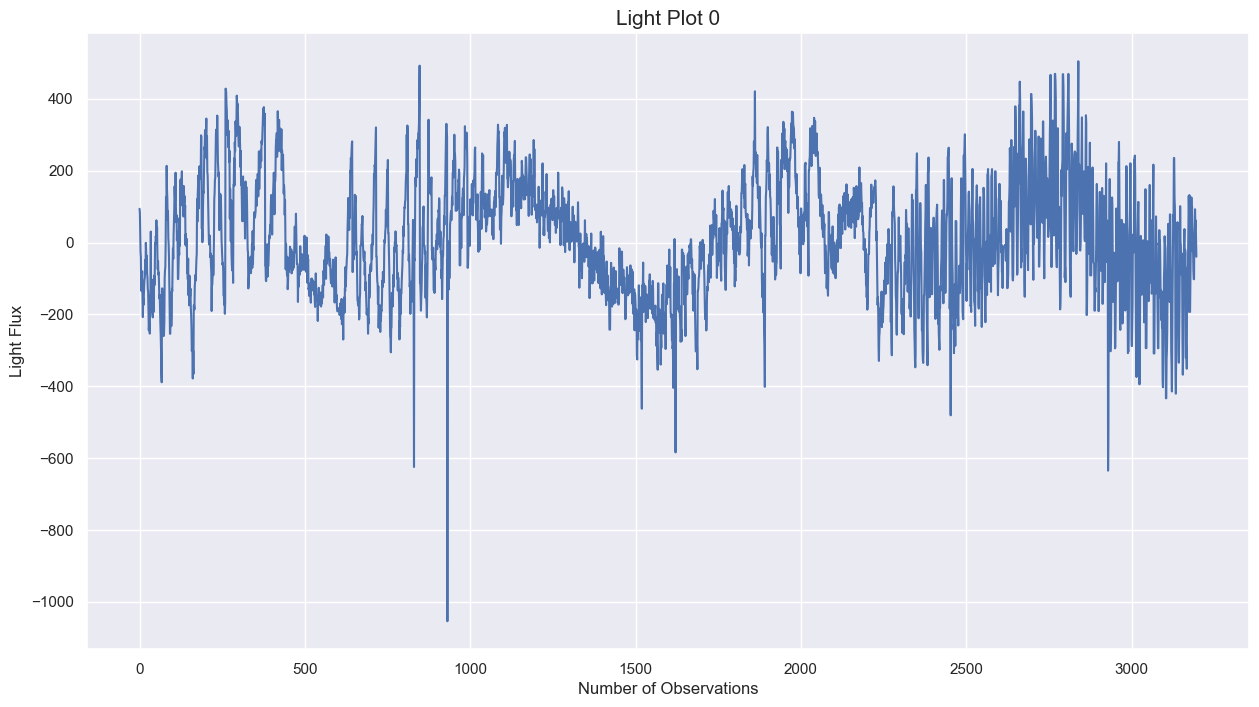

In [75]:
light_plot(0) # explaneta

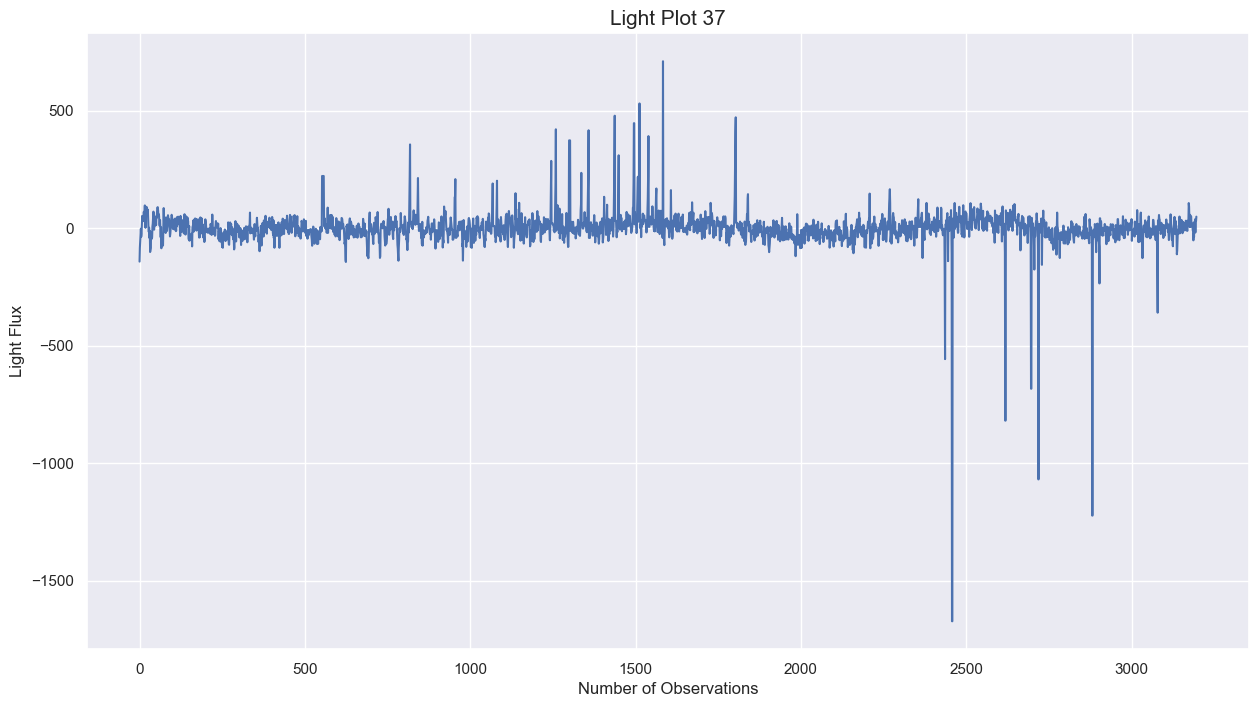

In [76]:
light_plot(37)# nao-exoplaneta

Há quedas claras nos dados, mas não são periódicas ao longo do gráfico. A frequência das quedas não se repete de forma consistente. Apenas esta evidência não é suficiente determinar a presença de um exoplaneta.

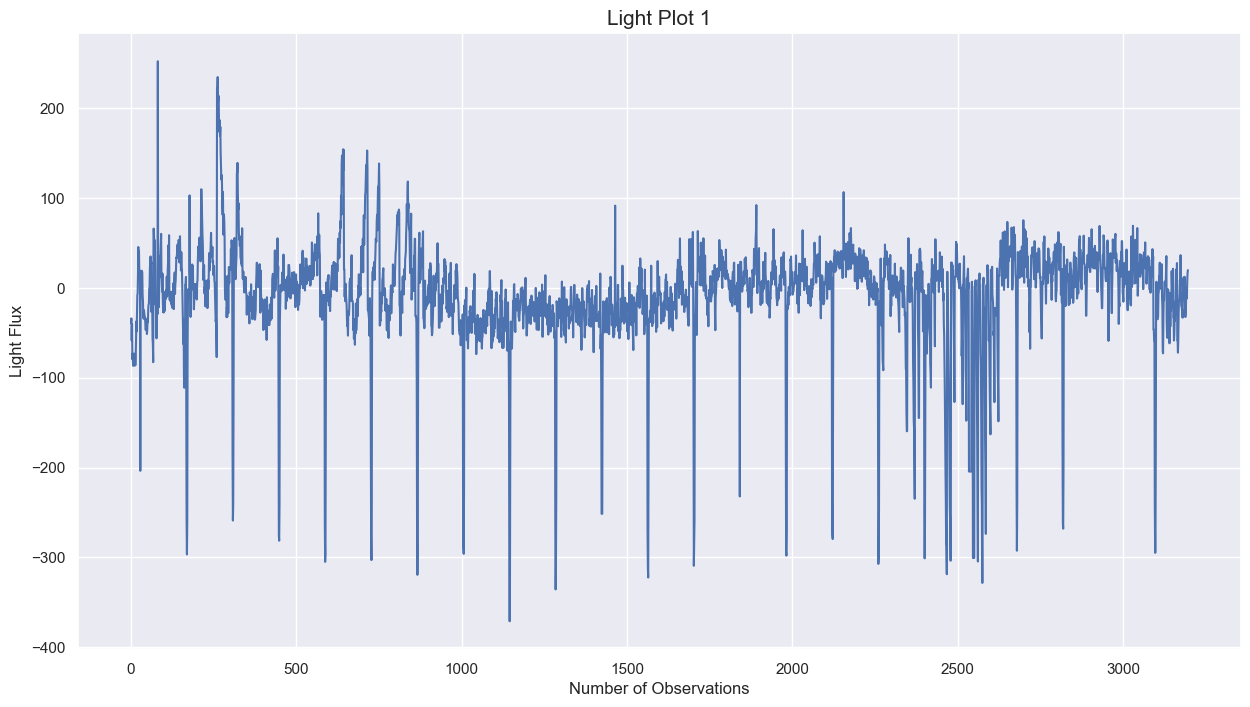

In [77]:
light_plot(1) # exoplaneta

O gráfico mostra uma periodicidade clara com grandes quedas no fluxo de luz, tornando um exoplaneta extremamente provável! Se todos os gráficos fossem tão claros, o aprendizado de máquina seria desnecessário. Como os outros gráficos revelam, concluir que um exoplaneta está presente geralmente não é tão claro.

> Embora esse conjunto de dados seja uma série temporal, o objetivo não é prever o fluxo de luz para a próxima unidade de tempo, mas classificar a estrela com base em todos os dados. A este respeito, classificadores de aprendizado de máquina podem ser usados para prever se uma determinada estrela hospeda um exoplaneta. A ideia é treinar o classificador nos dados fornecidos, que por sua vez podem ser usados para prever exoplanetas em novos dados. Aqui, tentaremos classificar os exoplanetas dentro dos dados usando o XGBClassifier. Antes de passarmos para classificar os dados, devemos primeiro preparar os dados.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 9.8 MB


In [79]:
# para cada coluna e, depois, para somar todas as colunas
df.isnull().sum().sum()

0

In [80]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [81]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2, verbosity=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 0.89


Pergunta: você obteve 89% de acurácia, mas os exoplanetas representam 10% dos dados, então como você sabe que seus resultados não são melhores do que um modelo que não prevê exoplanetas 100% do tempo?

> Aí está a questão. Se o modelo determinar que nenhuma estrela contém exoplanetas, sua acurácia será de aproximadamente 90%, pois 9 em cada 10 estrelas não contêm exoplanetas.

> com dados desbalanceados, acurácia não é suficiente

> podemos usar a matrix de confusao para analisar melhor o resultado

In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
# 86 nao-exoplanetas corretamente classificados e apenas 3 exoplanetas corretamente classificados

array([[86,  2],
       [ 9,  3]], dtype=int64)

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        88
           1       0.60      0.25      0.35        12

    accuracy                           0.89       100
   macro avg       0.75      0.61      0.65       100
weighted avg       0.87      0.89      0.87       100



Ao escolher um método de score, é fundamental entender o objetivo. O objetivo no conjunto de dados Exoplanet é encontrar exoplanetas. Isso é óbvio. O que não é óbvio é como selecionar o melhor método de score para alcançar os resultados desejados.

Imagine dois cenários diferentes:

* Cenário 1: Das 4 estrelas de exoplanetas que o modelo de aprendizado de máquina prevê, 3 são na verdade estrelas de exoplanetas: precision = 3/4 = 75%.

* Cenário 2: Das 12 estrelas de exoplanetas, o modelo prevê corretamente 8 estrelas de exoplanetas. recall = 8/12 = 66%.

A resposta é que depende. O Recall é ideal para sinalizar possíveis casos positivos (exoplanetas) com o objetivo de encontrar todos eles. Precision é ideal para garantir que as previsões (exoplanetas) sejam realmente positivas.

Supondo que o objetivo do modelo de aprendizado de máquina seja encontrar o maior número possível de exoplanetas, o recall é uma excelente escolha. Por quê? Recall nos diz quantas das 12 estrelas de exoplanetas foram encontradas (2/12, 5/12, 12/12).

In [84]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, pos_label=1) #deixando claro que a classe positiva é a 2

0.25

## Tratando dados desbalanceados

Agora que temos um método de score apropriado para descobrir exoplanetas, é hora de explorar estratégias como resampling, undersampling e oversampling para corrigir os dados desequilibrados que causam a recall baixo.

* Uma estratégia para neutralizar dados desequilibrados é reamostrar os dados. É possível subamostrar os dados reduzindo as linhas da classe majoritária e superamostrando os dados repetindo as linhas da classe minoritária.

Vamos escrever uma função que nos permite subamostrar os dados por qualquer número de linhas. A função a seguir usa o XGBClassifier e o número de linhas como entrada e produz confusion matrix, classification report e recall score.

In [85]:
def xgb_clf(model, nrows):

    df = pd.read_csv('bases/exoplanets.csv', nrows=nrows)
    df['LABEL'] = df['LABEL'].replace(1, 0)
    df['LABEL'] = df['LABEL'].replace(2, 1)

    df['LABEL'].value_counts()
    # Split data into X and y
    X = df.iloc[:,1:]
    y = df.iloc[:,0]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

    # Fit xg_reg to training set
    model.fit(X_train, y_train)

    # Predict labels of test set, y_pred
    y_pred = model.predict(X_test)

    score = recall_score(y_test, y_pred, pos_label=1)
    
    print(confusion_matrix(y_test, y_pred))
    
    print(classification_report(y_test, y_pred))
        
    return score

In [86]:
xgb_clf(XGBClassifier(random_state=2), nrows=800)

[[190   0]
 [  9   1]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       190
           1       1.00      0.10      0.18        10

    accuracy                           0.95       200
   macro avg       0.98      0.55      0.58       200
weighted avg       0.96      0.95      0.94       200



0.1

In [87]:
xgb_clf(XGBClassifier(random_state=2), nrows=200)

[[37  0]
 [ 9  4]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        37
           1       1.00      0.31      0.47        13

    accuracy                           0.82        50
   macro avg       0.90      0.65      0.68        50
weighted avg       0.86      0.82      0.78        50



0.3076923076923077

In [88]:
xgb_clf(XGBClassifier(random_state=2), nrows=74)

[[5 3]
 [3 8]]
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.73      0.73      0.73        11

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



0.7272727272727273

Outra técnica de reamostragem é a oversampling. Em vez de eliminar linhas, oversampling adiciona linhas copiando e redistribuindo os casos positivos.

Nossa estratégia é a seguinte:

* Crie um novo DataFrame que copie os casos positivos nove vezes.

* Concatene um novo DataFrame com o original para obter uma proporção de 10-10.

Antes de prosseguir, um aviso. Se os dados forem reamostrados antes de serem divididos em conjuntos de treinamento e teste, o recall será inflado.

Na reamostragem, serão feitas nove cópias dos casos positivos. Depois de dividir esses dados em conjuntos de treinamento e teste, as cópias provavelmente estarão contidas em ambos os conjuntos. Portanto, o conjunto de teste conterá a maioria dos mesmos pontos de dados que o conjunto de treinamento.

A estratégia apropriada é dividir os dados em um conjunto de treinamento e teste primeiro e depois reamostrar os dados:

In [89]:
df_train = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [90]:
newdf = pd.DataFrame(np.repeat(df_train[df_train['LABEL']==1].values,9,axis=0))
newdf.columns = df_train.columns
df_train_resample = pd.concat([df_train, newdf])

df_train_resample['LABEL'].value_counts()

LABEL
0.0    275
1.0    250
Name: count, dtype: int64

In [91]:
X_train_resample = df_train_resample.iloc[:,1:]
y_train_resample = df_train_resample.iloc[:,0]

In [92]:
# Instantiate the XGBRegressor, xg_reg
model = XGBClassifier(random_state=2, verbosity=0)

# Fit xg_reg to training set
model.fit(X_train_resample, y_train_resample)

# Predict labels of test set, y_pred
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred, pos_label=1)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)

[[84  4]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        88
           1       0.50      0.33      0.40        12

    accuracy                           0.88       100
   macro avg       0.71      0.64      0.67       100
weighted avg       0.86      0.88      0.87       100

0.3333333333333333


Melhoramos um pouco o recall, mas aindaa longe do desejado. Vamos fazer um tunning dos hiperparametros do XGBoost

## Tuning XGBClassifier

vamos ajustar e dimensionar o XGBClassifier para obter o melhor valor de recall_score possível para o conjunto de dados Exoplanets. Primeiro, você ajustará os pesos usando scale_pos_weight e, em seguida, executará pesquisas de grade para encontrar a melhor combinação de hiperparâmetros. Além disso, você pontuará modelos para diferentes subconjuntos de dados antes de consolidar e analisar os resultados.

Scale_pos_weight é um hiperparâmetro usado para dimensionar o peso positivo. A ênfase aqui no positivo é importante porque o XGBoost assume que um valor alvo de 1 é positivo e um valor alvo de 0 é negativo.

No conjunto de dados Exoplanet, usamos o padrão 1 como negativo e 2 como positivo, conforme fornecido pelo conjunto de dados. Agora vamos mudar para 0 como negativo e 1 como positivo usando o método .replace().

In [93]:
df['LABEL'] = df['LABEL'].replace(1, 0)
df['LABEL'] = df['LABEL'].replace(2, 1)

df['LABEL'].value_counts()

LABEL
0    400
Name: count, dtype: int64

In [94]:
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [95]:
model = XGBClassifier(scale_pos_weight=10, random_state=2,verbosity=0)

model.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score) # o mesmo resultado que foi obtido usando oversampling

[[100]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

0.0


In [96]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

In [97]:
#baseline
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=2)

model = XGBClassifier(scale_pos_weight=10, random_state=2,verbosity=0)

# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=kfold, scoring='recall')

# Display accuracy
print('Recall: ', scores)

# Display mean accuracy
print('Recall mean: ', scores.mean())

Recall:  [0. 0.]
Recall mean:  0.0


In [98]:
def grid_search(params, random=False, X=X, y=y, model=XGBClassifier(random_state=2, scale_pos_weight=10,
                                                                   verbosity=0, use_label_encoder=False)): 
    
    xgb = model
    
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_jobs=-1, random_state=2, scoring='recall')
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1, scoring='recall')
    
    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [99]:
grid_search(params={'n_estimators':[50, 200, 400, 800]})

Best params: {'n_estimators': 50}
Best score: 0.00000


In [100]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.2, 0.3]})

Best params: {'learning_rate': 0.01}
Best score: 0.00000


In [101]:
grid_search(params={'max_depth':[1, 2, 4, 8]})

Best params: {'max_depth': 1}
Best score: 0.00000


In [102]:
grid_search(params={'subsample':[0.3, 0.5, 0.7, 0.9]})

Best params: {'subsample': 0.3}
Best score: 0.00000


In [103]:
grid_search(params={'gamma':[0.05, 0.1, 0.5, 1]})

Best params: {'gamma': 0.05}
Best score: 0.00000


In [104]:
grid_search(params={'learning_rate':[0.001, 0.01, 0.03], 'max_depth':[1, 2], 'gamma':[0.025, 0.05, 0.5]})

Best params: {'gamma': 0.025, 'learning_rate': 0.001, 'max_depth': 1}
Best score: 0.00000


In [105]:
grid_search(params={'subsample':[0.3, 0.5, 0.7, 0.9, 1], 
                    'colsample_bylevel':[0.3, 0.5, 0.7, 0.9, 1], 
                    'colsample_bynode':[0.3, 0.5, 0.7, 0.9, 1], 
                    'colsample_bytree':[0.3, 0.5, 0.7, 0.9, 1]}, random=True)

Best params: {'subsample': 0.3, 'colsample_bytree': 0.7, 'colsample_bynode': 0.9, 'colsample_bylevel': 1}
Best score: 0.00000


In [106]:
#migrando para o dataset perfeitameente balanceado
X_short = X.iloc[:74, :]
y_short = y.iloc[:74]

In [107]:
grid_search(params={'max_depth':[1, 2, 3], 'colsample_bynode':[0.5, 0.75, 1]}, X=X_short, y=y_short, 
            model=XGBClassifier(random_state=2,verbosity=0,use_label_encoder=False))

Best params: {'colsample_bynode': 0.5, 'max_depth': 1}
Best score: 0.00000


In [108]:
# all dataset
df_all = pd.read_csv('bases/exoplanets.csv')
df_all['LABEL'] = df_all['LABEL'].replace(1, 0)
df_all['LABEL'] = df_all['LABEL'].replace(2, 1)

X_all = df_all.iloc[:,1:]
y_all = df_all.iloc[:,0]

In [109]:
df_all['LABEL'].value_counts()

LABEL
0    5050
1      37
Name: count, dtype: int64

In [110]:
weight = int(5050/37)

In [111]:
model = XGBClassifier(scale_pos_weight=weight, random_state=2,verbosity=0)

# Obtain scores of cross-validation
scores = cross_val_score(model, X_all, y_all, cv=kfold, scoring='recall')

# Display accuracy
print('Recall:', scores)

# Display mean accuracy
print('Recall mean:', scores.mean())

Recall: [0.10526316 0.        ]
Recall mean: 0.05263157894736842


In [112]:
grid_search(params={'learning_rate':[0.001, 0.01]}, X=X_all, y=y_all, model=XGBClassifier(scale_pos_weight=weight, 
                                                                                          random_state=2,
                                                                                         verbosity=0,
                                                                                         use_label_encoder=False))

Best params: {'learning_rate': 0.001}
Best score: 0.21053


In [113]:
grid_search(params={'max_depth':[1, 2],'learning_rate':[0.001]}, X=X_all, y=y_all, 
            model=XGBClassifier(scale_pos_weight=weight, random_state=2,verbosity=0,use_label_encoder=False))

Best params: {'learning_rate': 0.001, 'max_depth': 2}
Best score: 0.42982


In [114]:
def final_model(X, y, model):
    model.fit(X, y)
    y_pred = model.predict(X_all)
    score = recall_score(y_all, y_pred)
    print(score)
    print(confusion_matrix(y_all, y_pred))
    print(classification_report(y_all, y_pred))

In [115]:
# balanceado = 74 linhas
final_model(X_short, y_short, XGBClassifier(max_depth=2, colsample_by_node=0.5, random_state=2,
                                            verbosity=0,use_label_encoder=False))

0.0
[[5050    0]
 [  37    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5050
           1       0.00      0.00      0.00        37

    accuracy                           0.99      5087
   macro avg       0.50      0.50      0.50      5087
weighted avg       0.99      0.99      0.99      5087



In [116]:
# 400 linhas
final_model(X, y, XGBClassifier(max_depth=2, colsample_bynode=0.5, scale_pos_weight=10, random_state=2,
                               verbosity=0,use_label_encoder=False))

0.0
[[5050    0]
 [  37    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5050
           1       0.00      0.00      0.00        37

    accuracy                           0.99      5087
   macro avg       0.50      0.50      0.50      5087
weighted avg       0.99      0.99      0.99      5087



In [117]:
# todas as linhas
final_model(X_all, y_all, XGBClassifier(max_depth=2, colsample_bynode=0.5, 
                                        scale_pos_weight=weight, 
                                        random_state=2,
                                       verbosity=0,use_label_encoder=False))

1.0
[[5050    0]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087

